In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")
install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(32) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

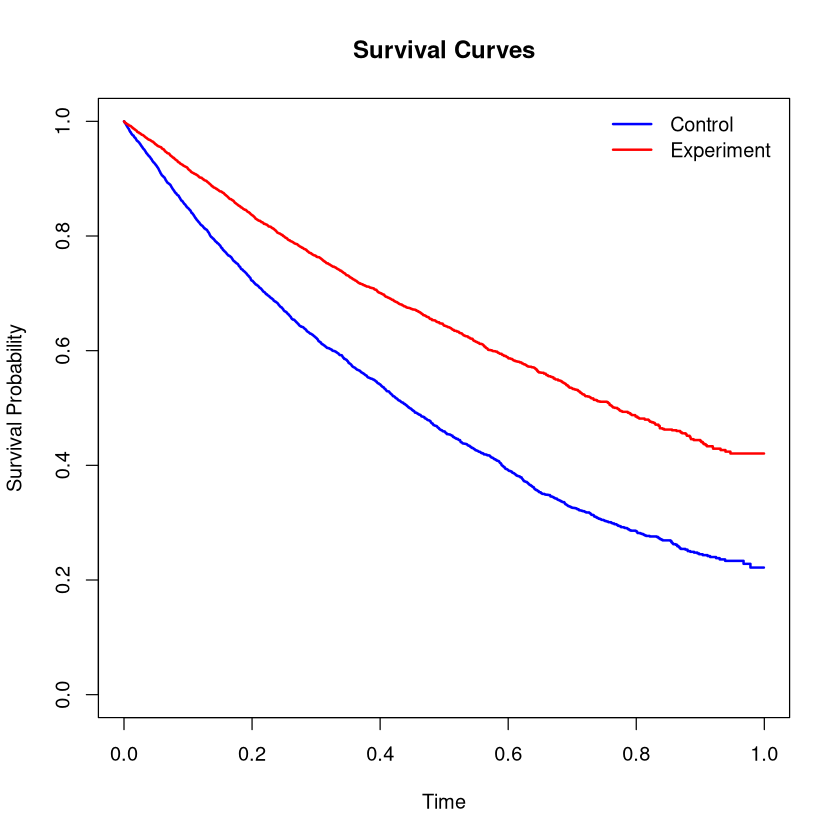

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

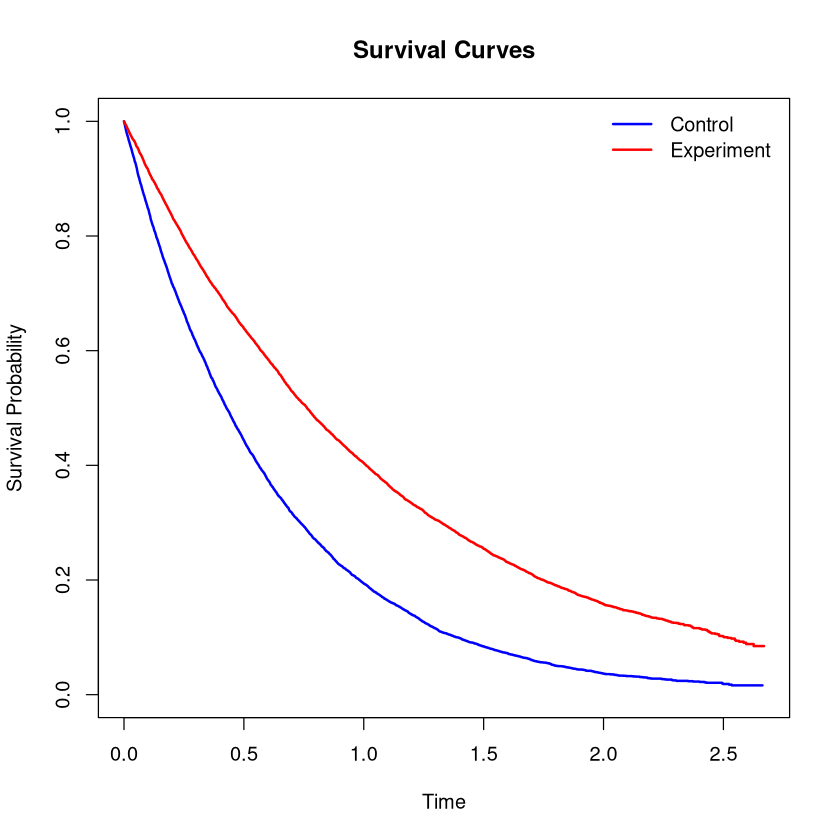

In [37]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$
#### Use my searching loop to find the critical value $m1, m2$

In [8]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

find_m_logrank(logrank_data = logrank_data, search_times = 1000, alpha = 0.05, sim_size = sim_size)


### Use the cut off point in Jung's paper
### <span style="color:yellow"> Same as the shown result in Jung's paper (yellow mark in the graph below)

In [ ]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.3803

[1] 0.0277

[1] 0.0501

[1] 0.7988

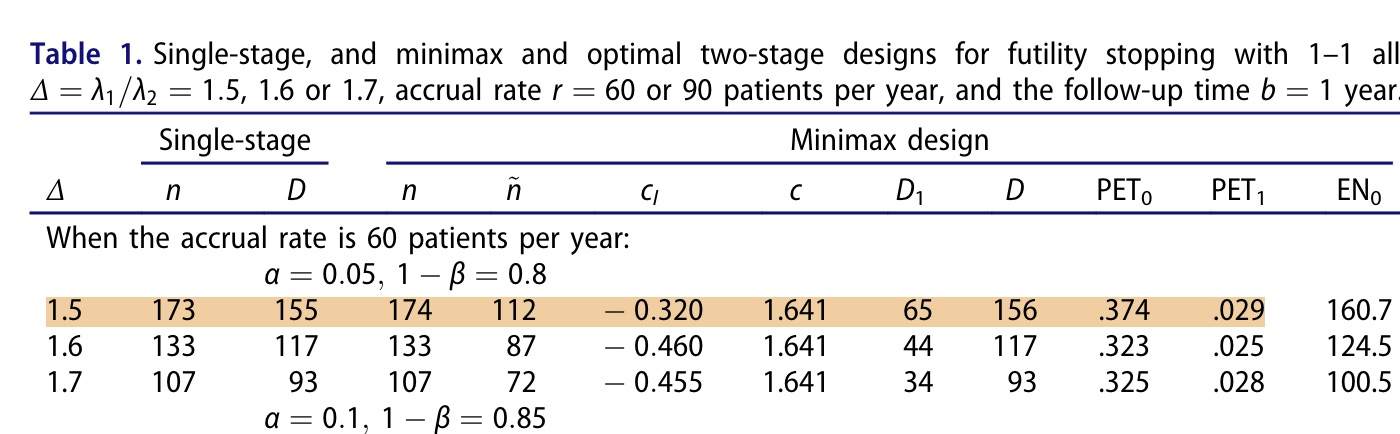

In [ ]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

#### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
#### This conclusion is true when stopping for both superiority and futility or for futility only.
#### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$
-------

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [3]:
set.seed(2024)
sim_size <- 10000 
N <- 200
r <- 100
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 1.2
HR <- 0.7
lambda_H1 <- 1.2 * HR
change_time <- 1
interim <- 1.4
n <- ceiling(N / 2)
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
                                
rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

# log-rank data
lr_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
lr_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                        sim_size =  sim_size, n = n, alpha = alpha, sided = 'greater')
# Get W/sigma
z_stats_h1_int <- lr_h1_int$z_stats
z_stats_h1_fin <- lr_h1_fin$z_stats
z_stats_h0_int <- lr_h0_int$z_stats
z_stats_h0_fin <- lr_h0_fin$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin) 
# corr(W1, W | H0)
corr_h0 <- sqrt(mean(lr_h0_int$var_w) / mean(lr_h0_fin$var_w))         


#### The mean and cov estimation shown above are packed in function 'mu_cov_mc'
#### The Estimation of $\mu\ and\ \Sigma | H_0,\ H_1$ are shown above 

------

# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ t_1,\ m_2,\ t_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\Large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}}
$$
#### $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 - C_1 > m_1) &= \mathcal{f}(n)  \\
\large P(E_1 - C_1 > m_1\ \&\ E_1 > t_1) &= \lambda · \mathcal{f}(n) \\
\large P(E_2 - C_2 > m_2) &=  \mathcal{f}(N) \\
\large P(E_2 - C_2 > m_2\ \&\ E_2 > t_2) &= \lambda · \mathcal{f}(N) \\
0<\lambda<1,\ \gamma>0
\end{aligned}
$$

#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size.  
#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ t_1,\ m_2,\ t_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(E_1-C_1>m_1\ \&\  E_1>t_1\ \&\  E_2 - C_2>m_2\ \&\  E_2>t_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ t_1,\ m_2,\ t_2$)

#### <span style="color:yellow"> Remark: for single stage design, we only search under the last two constraints.
#### * The grid searching procedure above is packed in function: 'adp_grid_src'

In [4]:
set.seed(2024)
best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
best_our

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.724655e-05,0.6461077,0.12908,0.8983987,0.99,0.14,0.626,0.0903,0.0377,0.8237


### Use the normality of 4d RMST to calculate the Type I error and Power
### * The alpha and power calculated in the function above is based on the simulated survival data

In [5]:
threshold <- as.numeric(best_our[1:4])
# Monte Carlo normal probability 
norm_sam_h0 <- mvrnorm(100000, mu = mu_cov_h0$mu, Sigma = mu_cov_h0$sigma)
norm_sam_h1 <- mvrnorm(100000, mu = mu_cov_h1$mu, Sigma = mu_cov_h1$sigma)

cat('The type one error is:',sum(apply(norm_sam_h0, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('The Power is:',sum(apply(norm_sam_h1, 1, function(x) all(x > threshold))) / 100000, '\n')

The type one error is: 0.03638 
The Power is: 0.80441 


### <span style="color:yellow">  The power is slightly higher than LR but cost should be global robustness (Litwin 2017)  
------


## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \frac{\lambda_E}{\lambda_C} = 0.67$ Follow Jung 2017 table1

In [6]:
best_lr <- find_m_logrank(logrank_data = logrank_data, search_times = 500, corr_h0 = corr_h0,
                 alpha = alpha, sim_size = sim_size)
best_rmst <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size, method = 'Simple')
best_lr
best_rmst

m1,m2,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.6779285,1.641859,0.255,0.0188,0.0476,0.7407


m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02468095,0,0.1613846,0,0.5,0.22,0.6076,0.1265,0.0498,0.7566


### Fix $\lambda_{C|H0}$, Change HR', the real hazard rate
#### under <span style="color:yellow"> the same critical value(cutoff) 
#### $H0: \lambda_E = \lambda_C = \lambda_{C|H0}$
#### $H1: \lambda_C =  \lambda_{C|H0},\ \lambda_E =  \lambda_{C|H0}*HR'$

In [34]:
m1 <- as.numeric(best_our[1])
t1 <- as.numeric(best_our[2])
m2 <- as.numeric(best_our[3])
t2 <- as.numeric(best_our[4])

# Critical value of LR and simple RMST
m1_lr <- best_lr$m1
m2_lr <- best_lr$m2
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

lambda_H1 <- 1.2 * 0.7
diff_HR_robust <- foreach(HR = seq(0.4, 0.9, by = 0.05), .combine = rbind) %dopar%
{
    lambda_H0 <- lambda_H1 / HR
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > t1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > t2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > t1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > t2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= t1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= t1)) / sim_size
   
    return(c(HR1, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
            pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}

In [35]:
#save(diff_HR_robust, file = '/home/r27user6/RMST_Code/RData/diff_HR_robust.RData')
# load(file = '/home/r27user6/RMST_Code/RData/diff_HR_robust.RData')

p_HR <- compare_line_plot(data = diff_HR_robust, var_name = 'Hazard_Ratio_1')

ggsave("Early_diff_robust.pdf", plot = p_HR, width = 10, height = 7, limitsize = FALSE)

-------

In [31]:
m1 <- as.numeric(best_our[1])
t1 <- as.numeric(best_our[2])
m2 <- as.numeric(best_our[3])
t2 <- as.numeric(best_our[4])
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

best_our
best_rmst

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.724655e-05,0.6461077,0.12908,0.8983987,0.99,0.14,0.626,0.0903,0.0377,0.8237


m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02468095,0,0.1613846,0,0.5,0.22,0.6076,0.1265,0.0498,0.7566


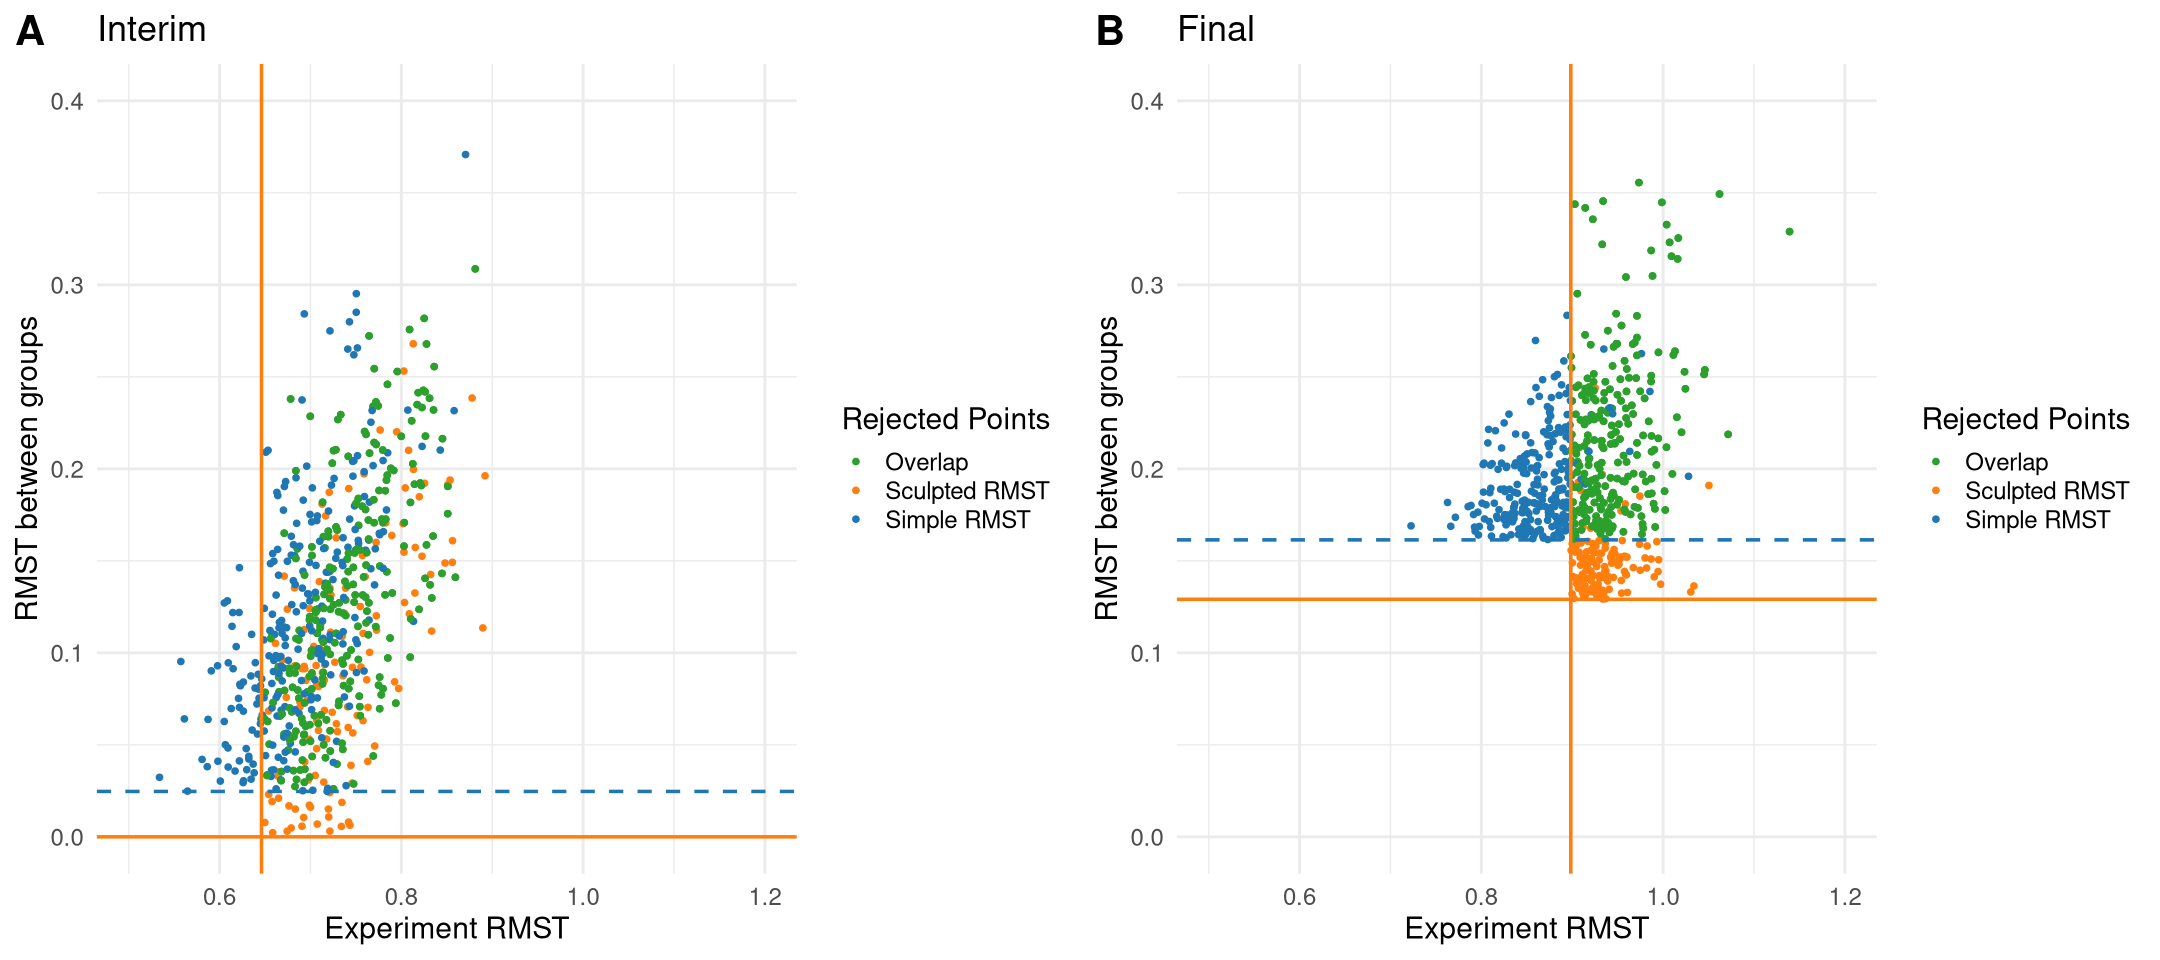

In [90]:
rmst_data <- rbind(rmst_h0_int, rmst_h0_fin)
D1 <- rmst_data[2,] - rmst_data[1,]
R1 <- rmst_data[2,]
D2 <- rmst_data[4,] - rmst_data[3,]
R2 <- rmst_data[4,]
# Rejection region
Scu_R <- as.matrix(rmst_data[, which(D1 > m1 & R1 > t1 & D2 > m2 & R2 > t2)])
Sim_R <- as.matrix(rmst_data[, which(D1 > m1_rmst & D2 > m2_rmst)])

# Prepare data for the first scatterplot
data1 <- data.frame(
  x = c(Scu_R[2, ], Sim_R[2, ]),
  y = c(Scu_R[2, ] - Scu_R[1, ], Sim_R[2, ] - Sim_R[1, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data1 <- data1 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

plot1 <- ggplot(data1, aes(x = x, y = y, color = overlap)) +
  geom_point(size = 1.5) +
  scale_color_manual(values = c("Simple RMST" = "#1f77b4", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#2ca02c")) +
  labs(title = "Interim", x = "Experiment RMST", y = "RMST between groups", color = "Rejected Points") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.2) +
  ylim(0, 0.4)+
  geom_hline(aes(yintercept = m1_rmst), color = "#1f77b4", size = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m1), color = "#ff7f0e", size = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = t1), color = "#ff7f0e", size = 1, linetype = "solid", show.legend = FALSE)

# Prepare data for the second scatterplot
data2 <- data.frame(
  x = c(Scu_R[4, ], Sim_R[4, ]),
  y = c(Scu_R[4, ] - Scu_R[3, ], Sim_R[4, ] - Sim_R[3, ]),
  group = rep(c("Sculpted RMST", "Simple RMST"), times = c(ncol(Scu_R), ncol(Sim_R)))
)
data2 <- data2 %>%
  group_by(x, y) %>%
  mutate(overlap = ifelse(n() > 1, "Overlap", group)) %>%
  ungroup()

plot2 <- ggplot(data2, aes(x = x, y = y, color = overlap)) +
  geom_point(size = 1.5) +
  scale_color_manual(values = c("Simple RMST" = "#1f77b4", "Sculpted RMST" = "#ff7f0e", "Overlap" = "#2ca02c")) +
  labs(title = "Final", x = "Experiment RMST", y = "RMST between groups", color = "Rejected Points") +
  theme_minimal(base_size = 18) +
  xlim(0.5, 1.2) +
  ylim(0, 0.4)+
  geom_hline(aes(yintercept = m2_rmst), color = "#1f77b4", size = 1, linetype = "dashed", show.legend = FALSE) +
  geom_hline(aes(yintercept = m2), color = "#ff7f0e", size = 1, linetype = "solid", show.legend = FALSE) +
  geom_vline(aes(xintercept = t2), color = "#ff7f0e", size = 1, linetype = "solid", show.legend = FALSE)


options(repr.plot.width = 18, repr.plot.height = 8)
combined_plot <- plot_grid(plot1, plot2, labels = c("A", "B"), label_size = 25, ncol = 2)
print(combined_plot)

### 245 green dots, 132 orange and 253 blue

In [87]:
Scu_R
Sim_R

,result.4,result.10,result.16,result.40,result.50,result.58,result.142,result.173,result.195,result.206,⋯,result.9702,result.9748,result.9782,result.9786,result.9862,result.9868,result.9885,result.9890,result.9948,result.9987
Est.,0.5034040,0.6156522,0.6856334,0.6395203,0.5938563,0.7158884,0.6561951,0.6993354,0.6455045,0.5860678,⋯,0.6098769,0.5393435,0.7371315,0.6644890,0.6301287,0.7761448,0.6417293,0.6148414,0.6404683,0.5905637
Est.,0.7301894,0.7371792,0.8261099,0.7621513,0.7485288,0.7346256,0.6584492,0.8481322,0.6985401,0.7213668,⋯,0.6948868,0.7596030,0.7434516,0.7144977,0.7153377,0.8896836,0.7401141,0.7023305,0.6919371,0.7147400
Est.,0.5884765,0.7962928,0.7799979,0.7172449,0.7071343,0.7765287,0.7706164,0.8975525,0.7487686,0.7783278,⋯,0.8009637,0.6835568,0.7916657,0.7413896,0.8073539,0.8357445,0.6988951,0.7725755,0.7302270,0.7470414
Est.,0.9339504,0.9271776,0.9903622,0.9324981,0.9053632,0.9536954,0.9151798,1.0338777,0.9035087,0.9111722,⋯,0.9530373,0.9883552,0.9358624,0.9796426,0.9367819,0.9818544,0.9575621,0.9091329,0.9301502,0.9421336


,result.3,result.4,result.16,result.17,result.35,result.40,result.50,result.62,result.69,result.127,⋯,result.9768,result.9786,result.9795,result.9852,result.9885,result.9928,result.9942,result.9948,result.9957,result.9987
Est.,0.5605469,0.5034040,0.6856334,0.4926874,0.5415505,0.6395203,0.5938563,0.6164236,0.6342637,0.6064401,⋯,0.5893458,0.6644890,0.6176430,0.5871790,0.6417293,0.5621680,0.6106672,0.6404683,0.5797490,0.5905637
Est.,0.6463712,0.7301894,0.8261099,0.6145571,0.6485787,0.7621513,0.7485288,0.6766894,0.7222781,0.6505941,⋯,0.7013740,0.7144977,0.6739301,0.7125201,0.7401141,0.6844721,0.8228456,0.6919371,0.6756379,0.7147400
Est.,0.6267604,0.5884765,0.7799979,0.6149820,0.6737306,0.7172449,0.7071343,0.6781146,0.7003904,0.6384467,⋯,0.6818167,0.7413896,0.6628487,0.6223376,0.6988951,0.6983224,0.6503512,0.7302270,0.6416613,0.7470414
Est.,0.8274682,0.9339504,0.9903622,0.8023162,0.8505156,0.9324981,0.9053632,0.8461684,0.8898563,0.8260743,⋯,0.8458285,0.9796426,0.8747306,0.8093630,0.9575621,0.8745789,0.8589531,0.9301502,0.8194407,0.9421336
